In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pyhsmm_mvpa as hsmm
from pyhsmm_mvpa import simulations
import seaborn as sns
import pandas as pd
import multiprocessing
from mne import channels

In [2]:
cpus = 20
path = '../simulated/'
n_events = 600
sources = [['lateraloccipital-lh',1e-2, [np.random.gamma,2,10]],
           ['lateraloccipital-rh', 1e-2, [np.random.gamma, 2,50]],
           ['postcentral-lh', 1e-2, [np.random.gamma, 2, 50]],
           ['posteriorcingulate-rh', 1e-2, [np.random.gamma, 2,60]],
           ['postcentral-rh', 1e-2, [np.random.gamma, 2,450]],
           ['lateraloccipital-lh',1e-2, [np.random.gamma,2,10]],
           ['lateraloccipital-rh', 1e-2, [np.random.gamma, 2,75]],
           ['postcentral-lh', 1e-2, [np.random.gamma, 2, 50]],
           ['posteriorcingulate-rh', 1e-2, [np.random.gamma, 2,60]],
           ['postcentral-rh', 1e-2, [np.random.gamma, 2,150]],
           ['postcentral-lh', 1e-2, [np.random.gamma, 2,100]]]#Response trigger, amplitude scale make it hardly visible for hsmm

max_trial_length = 7000#ms

bump_frequency = 10.
file = 'dataset_long_rts_long_breaks'
mne_path = path+file+'_raw.fif'

raw, generating_events = simulations.simulate(sources, n_events, max_trial_length, cpus, bump_frequency, file, path, overwrite=False)

Aligning file name to MNE's convention
Simulating dataset_long_rts_long_breaks_raw.fif in simulated/


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

Writing /Users/p308410/projects/pyhsmm-mvpa/simulated/dataset_long_rts_long_breaks_raw.fif
Overwriting existing file.
Writing /Users/p308410/projects/pyhsmm-mvpa/simulated/dataset_long_rts_long_breaks_raw-1.fif
Overwriting existing file.
Writing /Users/p308410/projects/pyhsmm-mvpa/simulated/dataset_long_rts_long_breaks_raw-2.fif
Closing /Users/p308410/projects/pyhsmm-mvpa/simulated/dataset_long_rts_long_breaks_raw-2.fif
Closing /Users/p308410/projects/pyhsmm-mvpa/simulated/dataset_long_rts_long_breaks_raw-1.fif
Closing /Users/p308410/projects/pyhsmm-mvpa/simulated/dataset_long_rts_long_breaks_raw.fif
[done]
simulated/dataset_long_rts_long_breaks_raw.fif simulated


In [3]:
number_of_sources = len(np.unique(generating_events[:,2])[1:])
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

resp_trigger = int(np.max(np.unique(generating_events[:,2])))

i,x = 1,0                  
while x <len(random_source_times):
    for j in np.arange(number_of_sources):
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

events = generating_events[(generating_events[:,2] == 0) | (generating_events[:,2] == resp_trigger)]
event_id = {'stimulus':0}
resp_id = {'response':resp_trigger}
eeg_dat = hsmm.utils.read_mne_EEG([mne_path,], event_id, resp_id, raw.info['sfreq'],events)
hsmm_dat, PCs, explained_var, means = hsmm.utils.transform_data(eeg_dat.data,'',
        apply_standard=False,single=True, return_weights=True, n_comp=4)
hsmm_dat = hsmm.utils.stack_data(hsmm_dat,'',single=True)

Reading 0 ... 4234999  =      0.000 ...  7051.104 secs...
Adding metadata with 2 columns
600 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Using data from preloaded Raw for 600 events and 3124 original time points ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0.001 and 5 seconds


# Estimating a x bump model

In [4]:
init = hsmm.models.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50, cpus=16)
estimates = init.fit_single(number_of_sources-1)

Estimating parameters for 10 bumps model
Parameters estimated for 10 bumps model


### Visualizing results of the fit

In [5]:
selected = estimates
bump_times_selected = init.bump_times(selected.eventprobs)
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes_selected = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)

## Comparing with ground truth

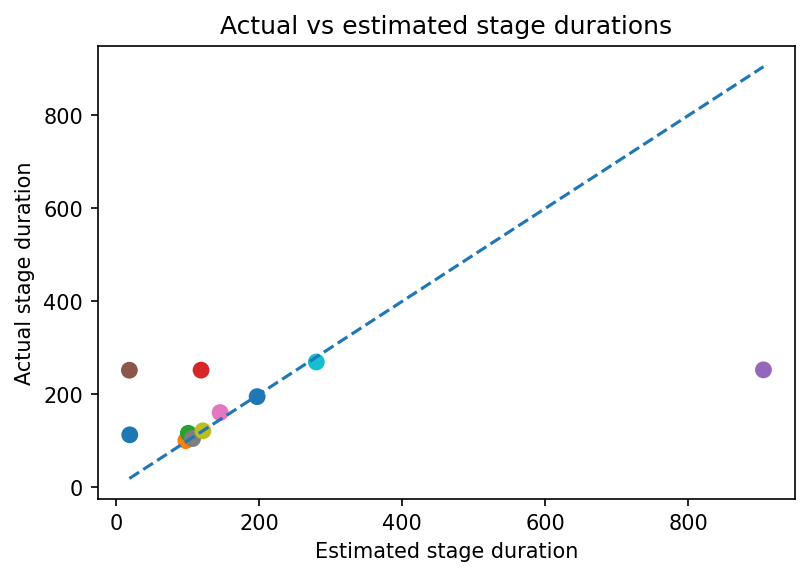

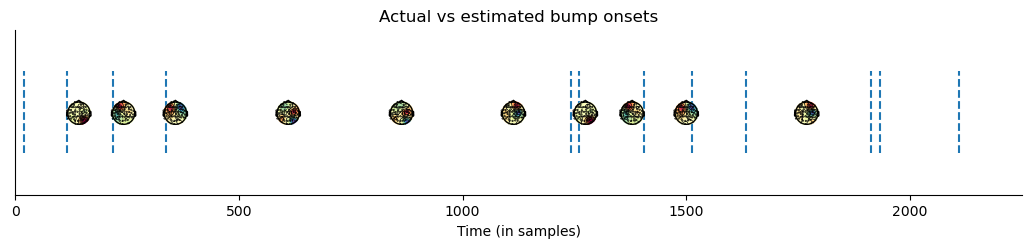

In [11]:
plt.figure(dpi=150)
colors = sns.color_palette(None, number_of_sources)#['darkblue','indianred','darkgreen','red','purple','grey']
#print(np.mean(random_source_times, axis=0)- (estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)])))
plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.utils.reconstruct(estimates.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, np.mean(init.bump_times(estimates.eventprobs), axis=0), positions,#inferring electrode location, 
        bump_size=init.bump_width_samples, time_step = 1, magnify=4, figsize=(13,2), title='Actual vs estimated bump onsets',
        times_to_display = np.concatenate([np.mean(np.cumsum(random_source_times,axis=1),axis=0),[np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data)]]))

#fig, ax= plt.subplots(5,1, figsize=(5,3.5*number_of_sources))
#ax[0].set_title('Comparing true vs estimated single trial stage durations')
#i = 0
#gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
#for bump in init.bump_times(estimates.eventprobs)[:,:number_of_sources-1].T:
#    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
#    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
#    i+= 1

# N_bump selection: iterative backward estimates

In [16]:
bests = init.backward_estimation()
bests

Estimating all solutions for maximal number of bumps (24) with 0 random starting points
Estimating parameters for 24 bumps model
Parameters estimated for 24 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 24, stage: 25, params: 2, component: 4, bump: 24, samples: 2998, trial: 529)
Coordinates:
  * n_bumps      (n_bumps) int64 24 23 22 21 20 19 18 17 16 ... 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 7.085e+04 7.54e+04 ... 2.257e+04 9.421e+03
    parameters   (n_bumps, stage, params) float64 2.0 8.641 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.9644 -0.9717 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

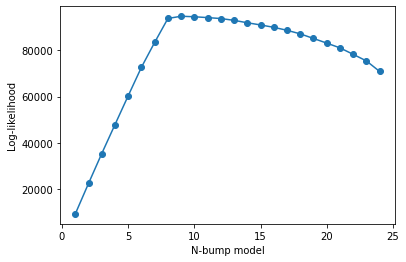

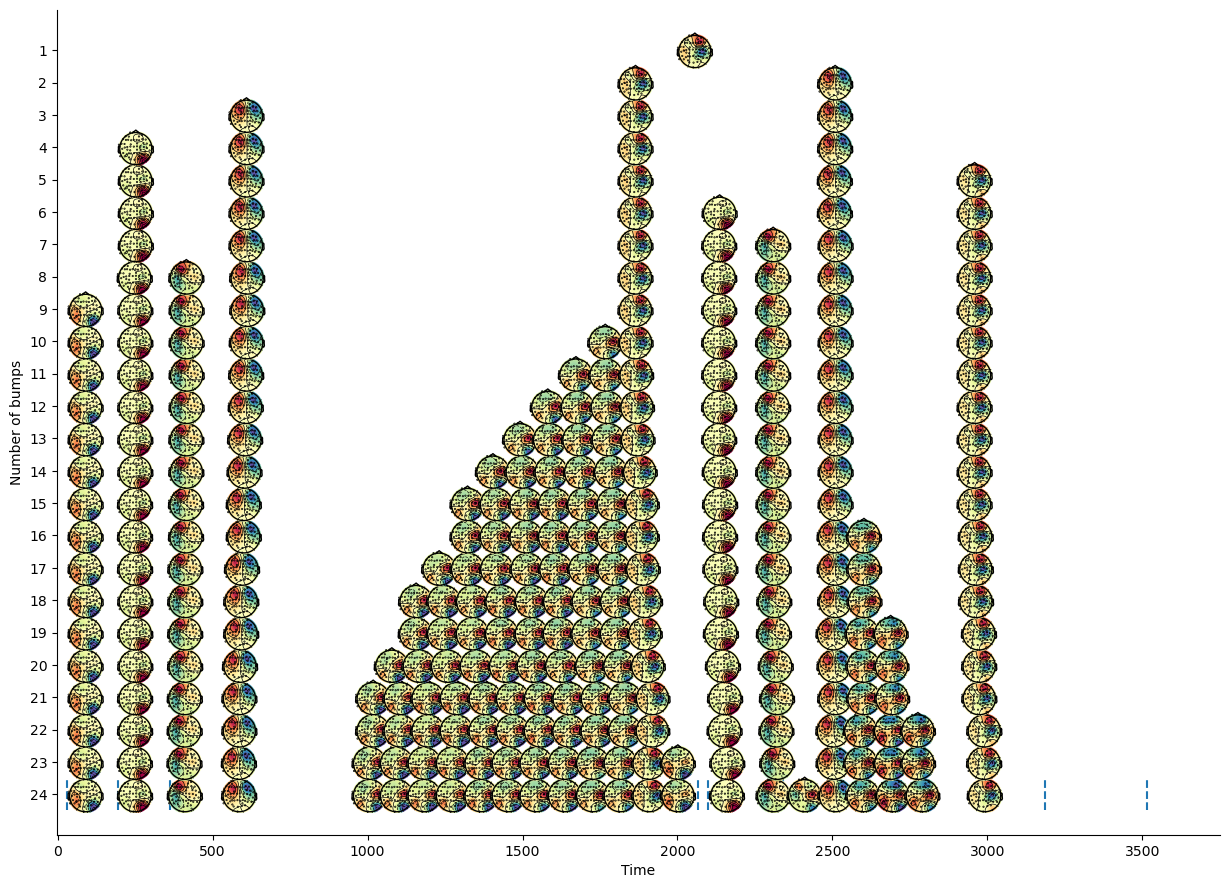

In [17]:
plt.plot(np.arange(init.max_bumps,0,-1), bests.likelihoods,'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-bump model')
plt.show()
electrodes = hsmm.utils.reconstruct(bests.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init.bump_times(x),axis=0) for x in bests.eventprobs], positions,
    bump_size=init.bump_width_samples, time_step = 1000/init.sf,  magnify=5, times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})

In [21]:
selected = bests.sel(n_bumps=10)
bump_times_selected = init.bump_times(selected.eventprobs.dropna('bump'))
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)
electrodes_selected = xr.DataArray(hsmm.utils.reconstruct(selected.magnitudes,PCs, explained_var, means))

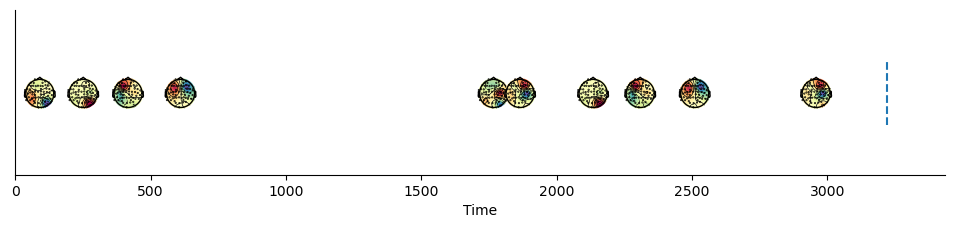

In [22]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1000/init.sf,  times_to_display = np.mean(init.ends - init.starts))

## Comparing with ground truth

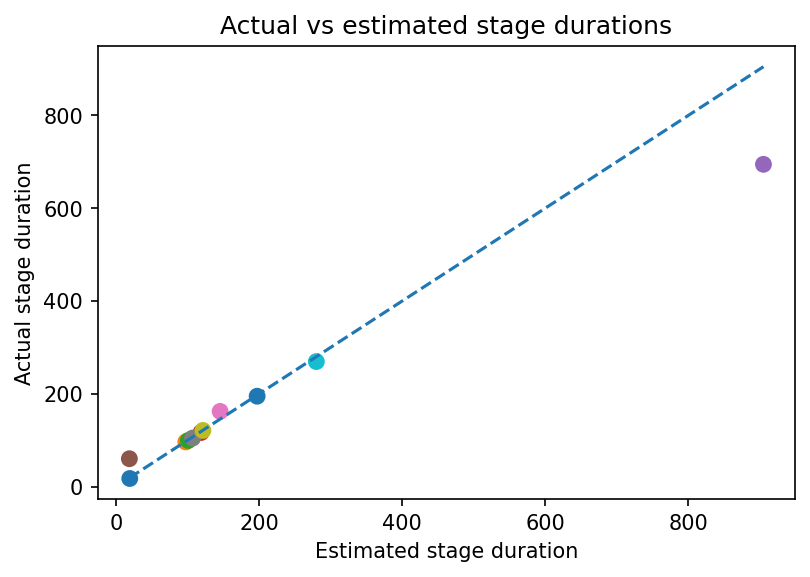

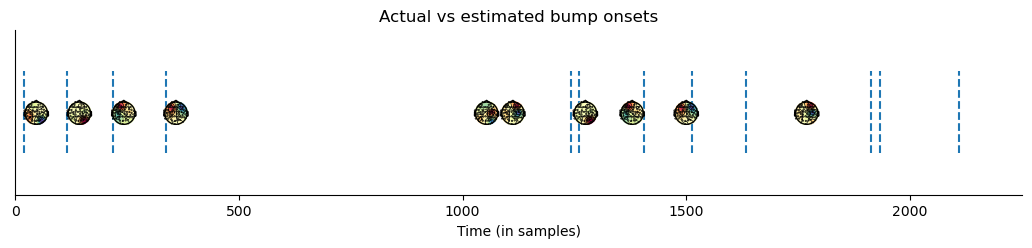

In [23]:
plt.figure(dpi=150)
colors = sns.color_palette(None, number_of_sources)#['darkblue','indianred','darkgreen','red','purple','grey']
#print(np.mean(random_source_times, axis=0)- (estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)])))
plt.scatter(np.mean(random_source_times, axis=0), selected.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, np.mean(init.bump_times(selected.eventprobs), axis=0), positions,#inferring electrode location, 
        bump_size=init.bump_width_samples, time_step = 1, magnify=4, figsize=(13,2), title='Actual vs estimated bump onsets',
        times_to_display = np.concatenate([np.mean(np.cumsum(random_source_times,axis=1),axis=0),[np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data)]]))

#fig, ax= plt.subplots(5,1, figsize=(5,3.5*number_of_sources))
#ax[0].set_title('Comparing true vs estimated single trial stage durations')
#i = 0
#gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
#for bump in init.bump_times(estimates.eventprobs)[:,:number_of_sources-1].T:
#    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
#    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
#    i+= 1

# Estimating a x bump model Re-estimating with random starting points

In [24]:
init = hsmm.models.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50, cpus=20)
estimates = init.fit_single(number_of_sources-1, starting_points = 200)

Estimating parameters for 10 bumps model
Parameters estimated for 10 bumps model


### Visualizing results of the fit

In [25]:
selected = estimates
bump_times_selected = init.bump_times(selected.eventprobs)
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes_selected = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)

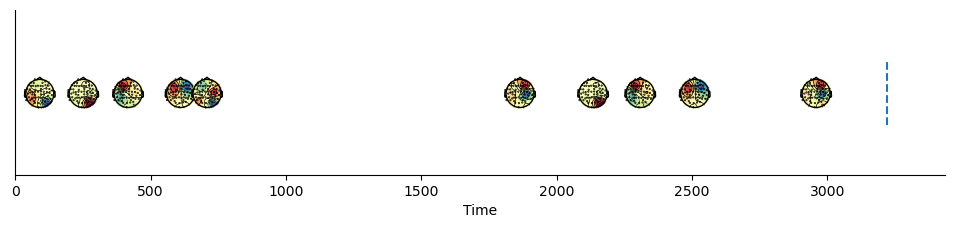

In [26]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1000/init.sf,  times_to_display = np.mean(init.ends - init.starts))

## Comparing with ground truth

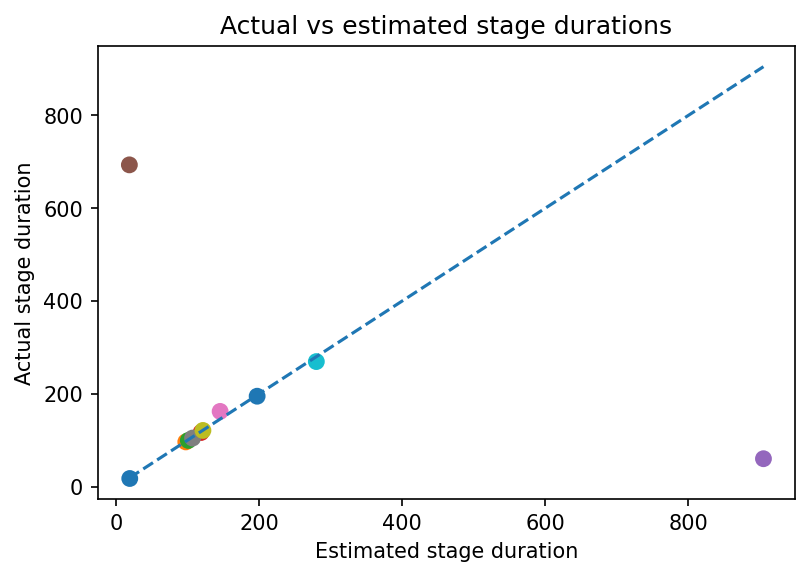

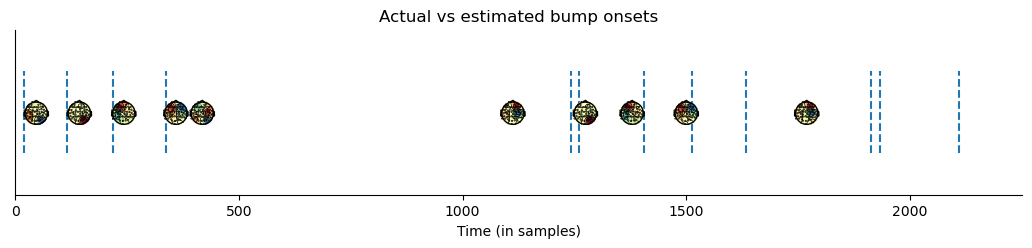

In [27]:
plt.figure(dpi=150)
colors = sns.color_palette(None, number_of_sources)#['darkblue','indianred','darkgreen','red','purple','grey']
#print(np.mean(random_source_times, axis=0)- (estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)])))
plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.utils.reconstruct(estimates.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, np.mean(init.bump_times(estimates.eventprobs), axis=0), positions,#inferring electrode location, 
        bump_size=init.bump_width_samples, time_step = 1, magnify=4, figsize=(13,2), title='Actual vs estimated bump onsets',
        times_to_display = np.concatenate([np.mean(np.cumsum(random_source_times,axis=1),axis=0),[np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data)]]))

#fig, ax= plt.subplots(5,1, figsize=(5,3.5*number_of_sources))
#ax[0].set_title('Comparing true vs estimated single trial stage durations')
#i = 0
#gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
#for bump in init.bump_times(estimates.eventprobs)[:,:number_of_sources-1].T:
#    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
#    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
#    i+= 1

# N_bump selection: iterative backward estimates

In [28]:
bests = init.backward_estimation(max_starting_points=200)
bests

Estimating all solutions for maximal number of bumps (24) with 199 random starting points
Estimating parameters for 24 bumps model
Parameters estimated for 24 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 24, stage: 25, params: 2, component: 4, bump: 24, samples: 2998, trial: 529)
Coordinates:
  * n_bumps      (n_bumps) int64 24 23 22 21 20 19 18 17 16 ... 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 7.286e+04 7.657e+04 ... 2.257e+04 9.421e+03
    parameters   (n_bumps, stage, params) float64 2.0 8.622 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.9642 -0.969 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

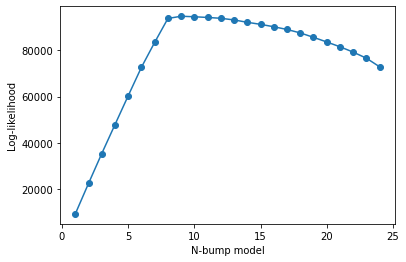

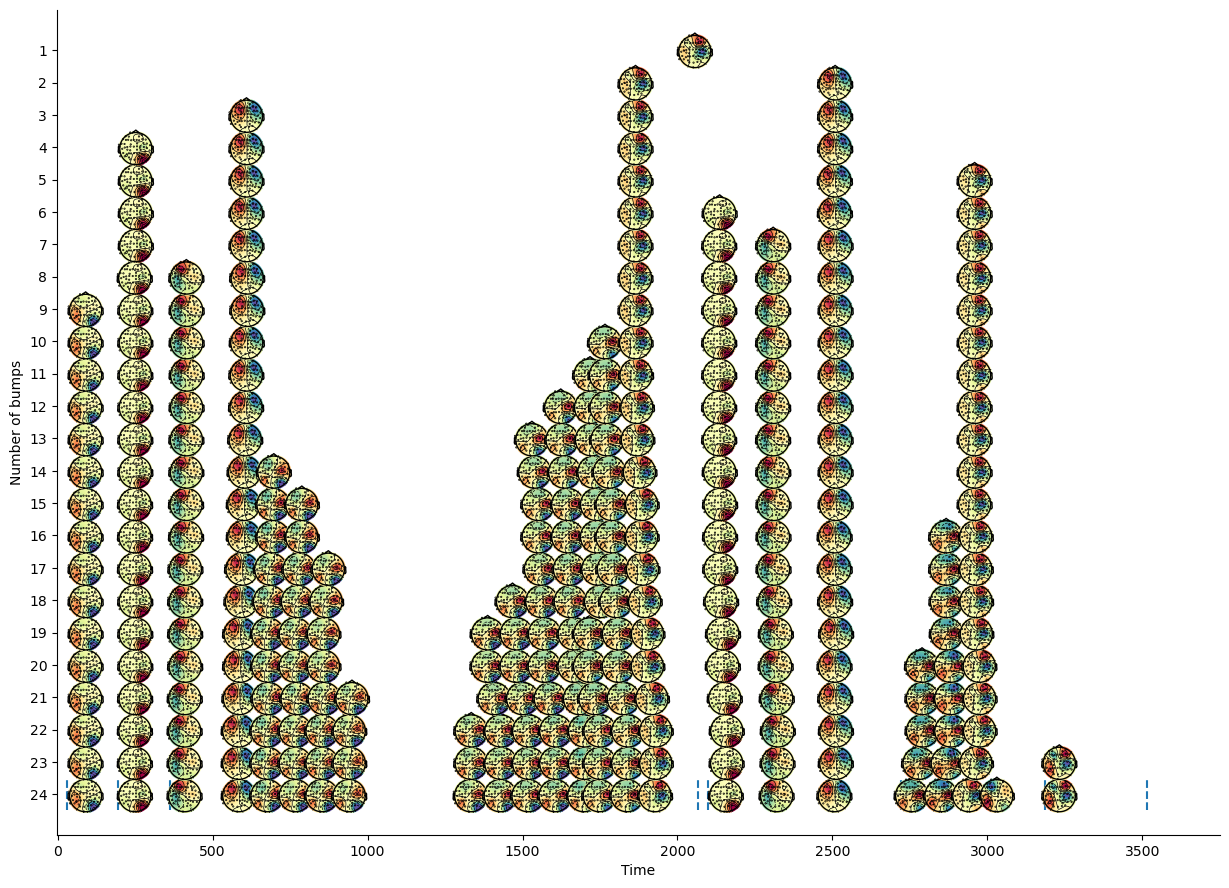

In [29]:
plt.plot(np.arange(init.max_bumps,0,-1), bests.likelihoods,'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-bump model')
plt.show()

electrodes = hsmm.utils.reconstruct(bests.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init.bump_times(x),axis=0) for x in bests.eventprobs], positions,
    bump_size=init.bump_width_samples, time_step = 1000/init.sf,  magnify=5, times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})


In [33]:
selected = bests.sel(n_bumps=10)
bump_times_selected = init.bump_times(selected.eventprobs.dropna('bump'))
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)
electrodes_selected = xr.DataArray(hsmm.utils.reconstruct(selected.magnitudes,PCs, explained_var, means))

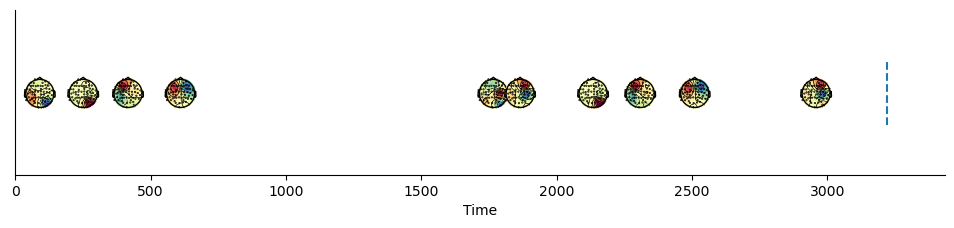

In [34]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1000/init.sf,  times_to_display = np.mean(init.ends - init.starts))

## Comparing with ground truth

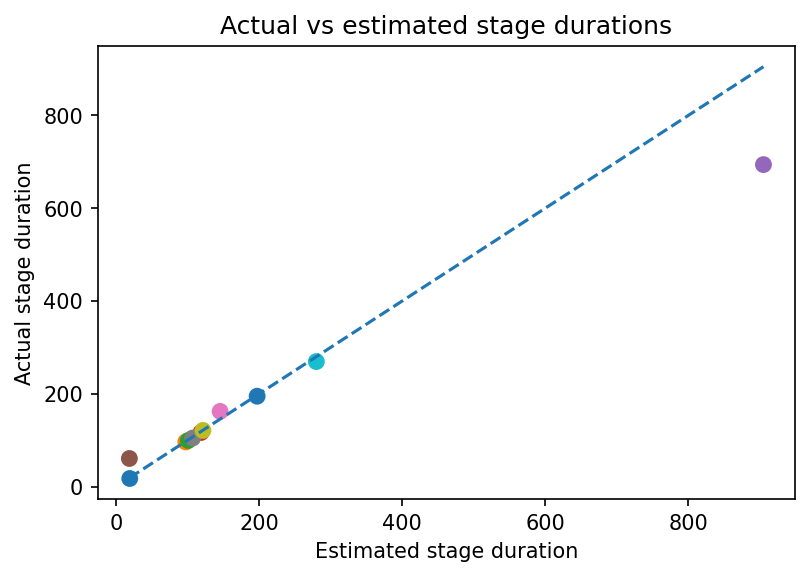

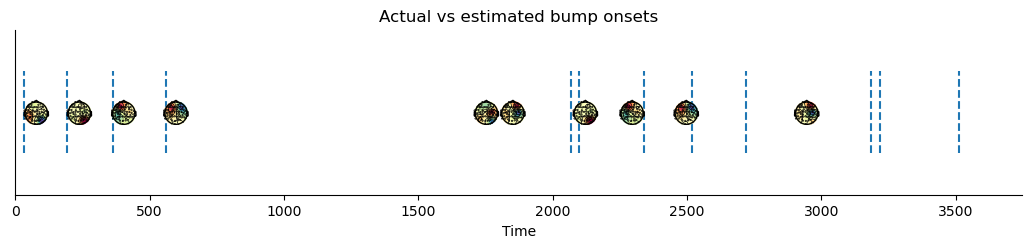

In [36]:
plt.figure(dpi=150)
colors = sns.color_palette(None, number_of_sources)#['darkblue','indianred','darkgreen','red','purple','grey']
#print(np.mean(random_source_times, axis=0)- (estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)])))
plt.scatter(np.mean(random_source_times, axis=0), selected.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, np.mean(init.bump_times(selected.eventprobs), axis=0), positions,#inferring electrode location, 
        bump_size=init.bump_width_samples, time_step = 1000/init.sf, magnify=4, figsize=(13,2), title='Actual vs estimated bump onsets',
        times_to_display = np.concatenate([np.mean(np.cumsum(random_source_times,axis=1),axis=0),[np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data)]]))

#fig, ax= plt.subplots(5,1, figsize=(5,3.5*number_of_sources))
#ax[0].set_title('Comparing true vs estimated single trial stage durations')
#i = 0
#gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
#for bump in init.bump_times(estimates.eventprobs)[:,:number_of_sources-1].T:
#    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
#    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
#    i+= 1